# Explore methods to estimate probability functions and to robustly estimate statistics in the presence of corrupted or missing data.

Aims:
1. Be able to estimate probability functions using several methods: per-feature 1D histograms, clustering for joint histograms, and mixture of Gaussian models.
2. Be able to estimate statistics, such as mean, standard deviation, min, and max while being robust to data values that are incorrect or missing.


### Part 1: Estimating PDFs

A basic problem in computer vision and graphics is being able to segment out an object based on a rough indication from a user. In this case, given a bounding box around an object, we want to identify which pixels correspond to the intended object.  

To do this, we compute two probabilities: (1) P(rgbi|image), the probability of the ith pixel’s color (RGB values) given that it comes from the image; and (2) P(rgbi|box), the probability of the ith pixel's color (RGB values) given that it comes from inside the bounding box.  We can then assign a score for whether a pixel is part of the object:

> score= log[P(rgbi |box)/P(rgbi|image)] 

This gives us a good pixelwise score for segmenting out the object inside the box.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


Whole image


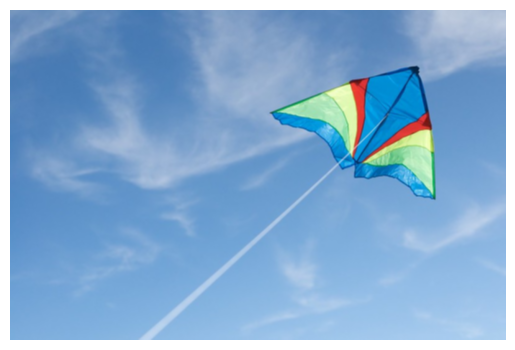

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.438607423491804e-16..0.9995642701525054].


Foreground


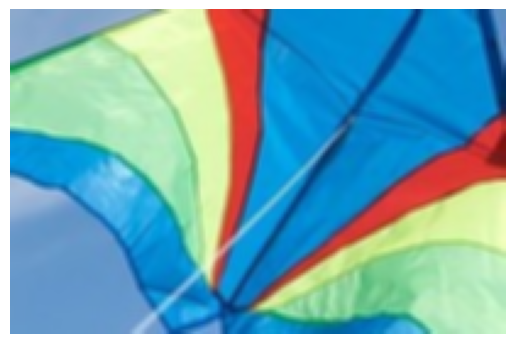

In [5]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# from google.colab import drive
import cv2

# read images
datadir = "./"
im = cv2.imread(datadir + 'kite.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3))

crop = cv2.imread(datadir + 'kite_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3))

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)


### Method 1 (per channel hist)

Estimate the probability of each color channel separately using discrete pdfs (by counting) and then model the joint probability as the product of per-channel probabilities.

In [6]:
def discretize(x, bins):
  x_discrete = np.zeros(x.shape, dtype='uint32') #uint so it can be used to index
  for i in range(1, len(bins)):
    x_discrete += (x > bins[i])
  x_discrete[x_discrete < 0] = 0
  x_discrete[x_discrete > (len(bins) - 2)] = len(bins) - 2
  return x_discrete

# estimate discrete pdf
def estimate_discrete_pdf(values, nvalues, prior = 0):
  '''
    Estimate P(values=v) for each possible v in (0, nvalues)
    Input:
      values: the values of the data
      nvalues: range of values, such that 0 <= values < nvalues
      prior: initial count used to prevent any value from having zero probability
    Output:
      p[nvalues,]: P(values=v) for each v
      bins : bin boundaries
      values_discrete : discretized values
  '''
  min_val = np.min(values)
  max_val = np.max(values)
  bins = range(nvalues + 1) * ((max_val - min_val) / nvalues) + min_val # defining bin boundaries
  bin_width = bins[1] - bins[0]
  values_discrete = discretize(values, bins) # discretized values in range of 0 to n-1

  pdf = np.ones(nvalues) * prior
  for v in values_discrete:
    pdf[v] += 1
  total = pdf.sum()
  for v in range(len(pdf)):
    pdf[v] = pdf[v] / total / bin_width

  return pdf, bins, values_discrete

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


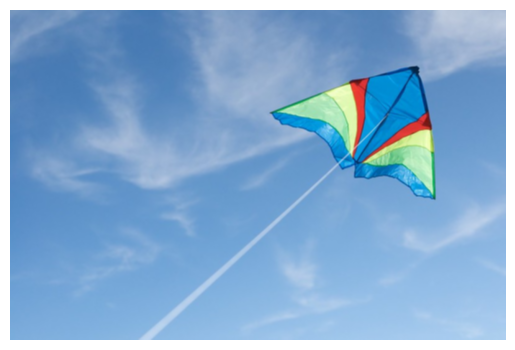

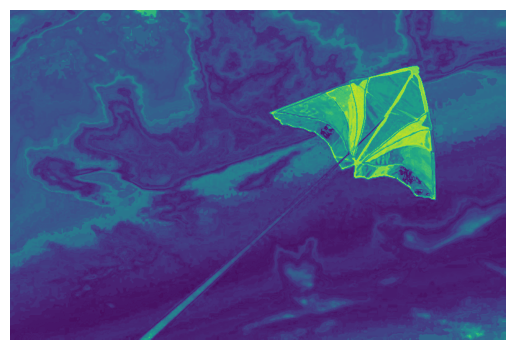

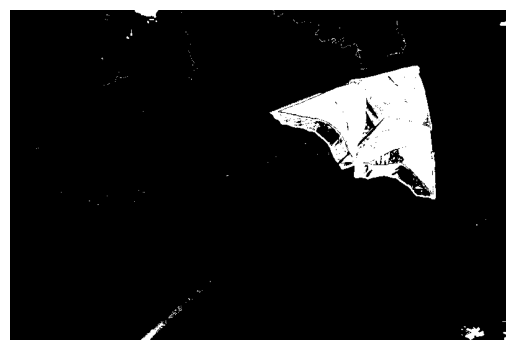

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


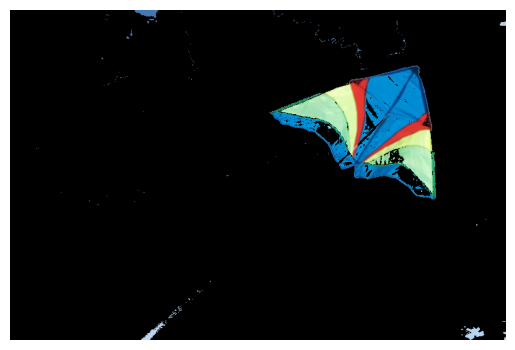

In [7]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))
nbins = 100

# estimate PDFs and compute score per pixel
pdf_img_channel1, _, d = estimate_discrete_pdf(im_3[:,0], nbins)
p_img_channel1 = pdf_img_channel1[d]

pdf_img_channel2, _, d = estimate_discrete_pdf(im_3[:,1], nbins)
p_img_channel2 = pdf_img_channel2[d]

p_img_channel3, _, d = estimate_discrete_pdf(im_3[:,2], nbins)
p_img_channel3 = p_img_channel3[d]

pdf_box_channel1, bins1, _ = estimate_discrete_pdf(crop_3[:,0], nbins)
p_box_channel1 = pdf_box_channel1[d]

pdf_box_channel2, bins2, _ = estimate_discrete_pdf(crop_3[:,1], nbins)
p_box_channel2 = pdf_box_channel2[d]

pdf_box_channel3, bins3, _ = estimate_discrete_pdf(crop_3[:,2], nbins)
p_box_channel3 = pdf_box_channel3[d]

p_pixel_image = p_img_channel1 * p_img_channel2 * p_img_channel3 # probability that a pixel belongs to image
p_pixel_box = pdf_box_channel1[discretize(im_3[:,0], bins1)] * pdf_box_channel2[discretize(im_3[:,1], bins2)] * pdf_box_channel3[discretize(im_3[:,2], bins3)] # probability that a pixel belongs to image

score = np.log(p_pixel_box / p_pixel_image)
t = 1
display_score(im=im, score_map=score, thresh=t)

### Method 2 (Kmeans)

Estimate the joint probability by k-means clustering the pixel colors in the whole image and then estimating the probability of each cluster.

In [8]:
# # init
# !apt install libomp-dev > /dev/null 2>&1
# !pip install faiss-cpu > /dev/null 2>&1
# import faiss
from sklearn.cluster import KMeans

/var/folders/8v/ytm_f1m10w538375k3jscfp00000gn/T/ipykernel_17835/3882000806.py:29: RuntimeWarning: divide by zero encountered in log
  score = np.log(p_pixel_box / p_pixel_img)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


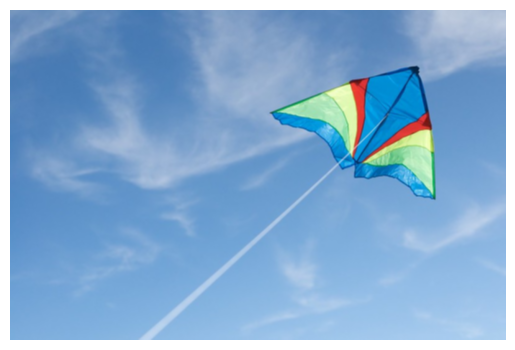

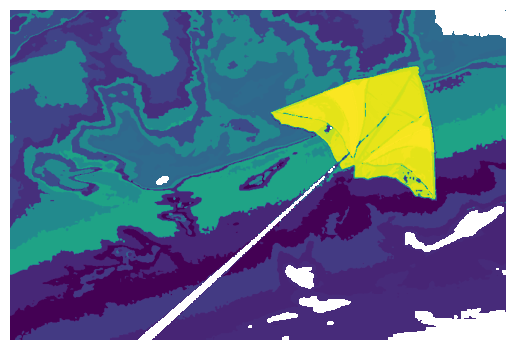

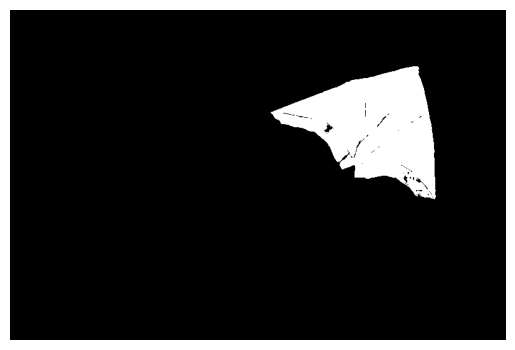

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


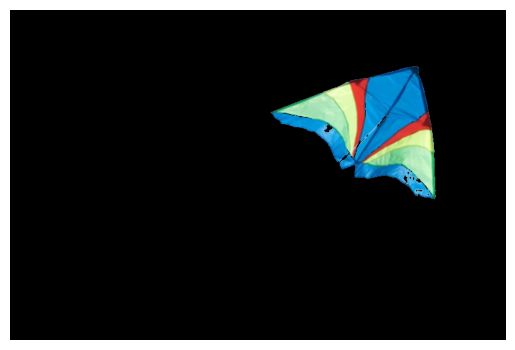

In [9]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))
nclusters = 30

kmeans_img = KMeans(n_clusters = nclusters, random_state = 0, n_init = "auto").fit(im_3)
pdf_img = np.zeros(nclusters)

for v in kmeans_img.labels_:
  pdf_img[v] += 1
total = pdf_img.sum()
for v in range(len(pdf_img)):
  pdf_img[v] = pdf_img[v] / total

# kmeans_box = KMeans(n_clusters = nclusters, random_state = 0, n_init = "auto").fit(crop_3)
pdf_box = np.zeros(nclusters)
box_clusters = kmeans_img.predict(crop_3)

for v in box_clusters:
  pdf_box[v] += 1
total = pdf_box.sum()
for v in range(len(pdf_box)):
  pdf_box[v] = pdf_box[v] / total

p_pixel_img = pdf_img[kmeans_img.labels_]
# img_box_clusters = kmeans_box.predict(im_3)
p_pixel_box = pdf_box[kmeans_img.labels_]

score = np.log(p_pixel_box / p_pixel_img)
t = 1
display_score(im=im, score_map=score, thresh=t)

### Method 3 (GMM)

Estimate the joint probability using a Gaussian mixture model (GMM).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


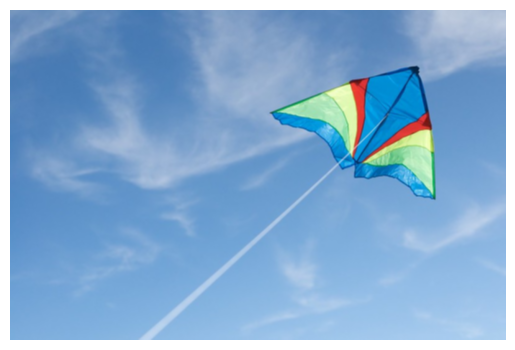

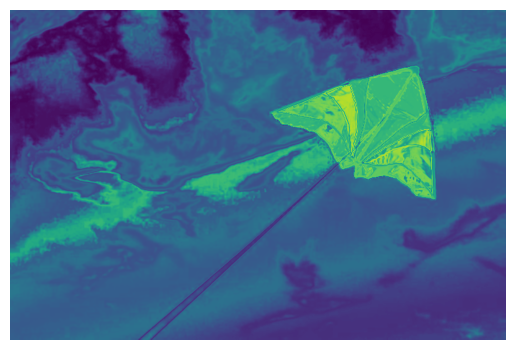

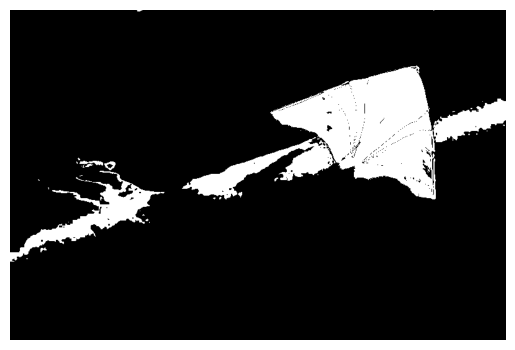

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0053686278550028e-15..1.0].


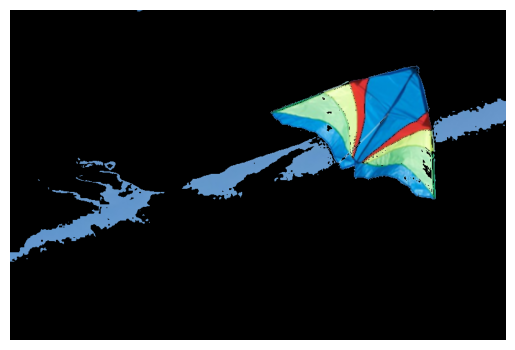

In [10]:
from sklearn.mixture import GaussianMixture

# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))
n_components = 8
covariance_type = 'diag'

# estimate PDFs and compute score per pixel (can use gmm.score_samples where gmm is the mixture model)
gmm_image = GaussianMixture(n_components = n_components, random_state = 0, covariance_type = covariance_type).fit(im_3)
gmm_box = GaussianMixture(n_components = n_components, random_state = 0, covariance_type = covariance_type).fit(crop_3)

score = gmm_box.score_samples(im_3) - gmm_image.score_samples(im_3)

t = -.01
display_score(im=im, score_map=score, thresh=t)

## Part 2: Robust Estimation

A corrupted salary dataset has three variables: salary, years, school. Salary is the reported salary of each person. Years is the number of years of experience in the job. School is the university where the person last had a degree. 

Some of the reported salary information is wrong (some incorrect value is provided), so we want to learn things from the data in a way that is robust to the wrong data. We refer to correctly entered data as “valid”.

We need to estimate the true mean, standard deviation, min, and max of the salaries.


In [11]:
import numpy as np
from matplotlib import pyplot as plt
# from google.colab import drive

datadir = "./"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

### 1. No noise

Assume no noise. Compute the statistics for the data as a whole.


In [12]:
# TO DO

salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)

print(f'Mean: {round(salary_mu)}  Std: {round(salary_std)}  Min: {round(salary_min)}   Max: {round(salary_max)}')

Mean: 123750  Std: 61954  Min: 64694   Max: 611494


### 2. Percentiles

Use percentiles. Assume valid data will fall between the 5th and 95th percentile. Adjust estimates of the min and max by assuming that the valid data has a uniform distribution.

In [13]:
pct = 0.05

# The intuition is that data statistics dependent on extremes (max, min) need to be extrapolated when you remove outliers,
# while other statistics (mean, std) can be accurately estimated from the inlier points.

# find max and min using 95th and 5th percentile
salary_max = np.percentile(salary, 95) + (np.percentile(salary, 95) - np.percentile(salary, 5)) * 0.05/0.9
salary_min = np.percentile(salary, 5) - (np.percentile(salary, 95) - np.percentile(salary, 5)) * 0.05/0.9

# # crop data according to calculated min and max
# salary_adj = salary[np.where((salary > salary_min) & (salary < salary_max))]

# crop data according to percentiles
salary_adj = salary[np.where((salary > np.percentile(salary, 5)) & (salary < np.percentile(salary, 95)))]

salary_mu = np.mean(salary_adj)
salary_std = np.std(salary_adj)

print(f'Mean: {round(salary_mu)}  Std: {round(salary_std)}  Min: {round(salary_min)}   Max: {round(salary_max)}')

Mean: 113879  Std: 15876  Min: 75494   Max: 159901


### 3. Expectation Maximization

Assume valid data follows a Gaussian distribution, while the wrong data has a uniform distribution between the minimum and maximum value of salary.  For mean and std, report the estimated mean and std of the valid salary distribution.  For min and max, we report the min and max salaries that have greater than 50% chance of being valid.  We also report the estimated probability that a random sample is valid, and the first five indices of salaries that are not likely to be valid.

In [14]:
'''
-initialize model params randomly

E-step
-use bayes rule to calculate
for each xi :
p(xi|valid) = gaussian formula
p(xi|invalid) = uniform distribution formula
p(valid|xi) = p(xi|valid)p(valid)/ (p(xi|valid)p(valid) + p(xi|invalid)p(invalid)
p(invalid|xi) = 1 - p(valid|xi)

M-step
-adjust model params using probabilty weighted estimates

'''
niter = 20

# initialize by assuming that all data is valid
mean = np.mean(salary)  # mu_i
std = np.std(salary)  # sigma
p_valid = 0.5 # P(valid) = 0.5 initially
p_invalid = 1 - p_valid
print(mean, std)

for t in range(niter):
  last_mean = mean
  last_std = std

  # E-step
  # update probability that each data point is valid
  p_valid_x = np.zeros((salary.shape[0],1))  # w_a = P(valid | salary, theta_t)
  for i, xi in enumerate(salary):
    # does xi look more like it comes from valid distribution or invalid distribution
    p_xi_valid = (1 / np.sqrt(2 * np.pi) / std) * np.exp(-1/2 * ((xi - mean) ** 2 / std ** 2)) # gaussian pdf
    p_xi_invalid = 1 / (np.max(salary) - np.min(salary)) # uniform pdf in range [min salary, max salary]

    # posterior
    p_valid_xi = (p_xi_valid * p_valid) / ((p_xi_valid * p_valid) + (p_xi_invalid * p_invalid))
    p_valid_x[i] = p_valid_xi

  print('\niter {}'.format(t))

  # M-step
  # assign parameters that maximize likelihood under latent variable likelihoods
  # estimate probability-weighted mean and std of valid distribution
  mean = 0
  for i, xi in enumerate(salary):
    mean += p_valid_x[i] * xi
  mean = mean / np.sum(p_valid_x)

  std = 0
  for i, xi in enumerate(salary):
    std += p_valid_x[i] * np.square(xi - mean)
  std = np.sqrt(std / np.sum(p_valid_x))

  # why didn't this work for above calculation?????
  # mean = np.sum(p_valid_x * salary) / np.sum(p_valid_x)
  # std = np.sqrt(np.sum(p_valid_x * np.square(salary - mean) / np.sum(p_valid_x)))

  # adjust priors
  p_valid = np.mean(p_valid_x)
  p_invalid = 1 - p_valid

  print(mean,std)
  if np.abs(last_mean - mean) < 0.00001 and np.abs(last_std - std) < 0.00001: # check for convergence
    break

# print(p_valid_x)
# for i, xi in enumerate(salary):
#     p_xi_valid = (1 / np.sqrt(2 * np.pi) / std) * np.exp(-1/2 * ((xi - mean) ** 2 / std ** 2))
#     p_xi_invalid = 1 / (np.max(salary) - np.min(salary))

#     p_valid_xi = (p_xi_valid * p_valid) / ((p_xi_valid * p_valid) + (p_xi_invalid * p_invalid))
#     p_valid_x[i] = p_valid_xi

salary_mu = mean[0]
salary_std = std[0]
salary_valid = salary[np.where(p_valid_x > 0.5)[0]]
salary_max = np.max(salary_valid)
salary_min = np.min(salary_valid)

print(f'Mean: {round(salary_mu)}  Std: {round(salary_std)}  Min: {round(salary_min)}   Max: {round(salary_max)}')

# # print the first five indices of salaries that are not likely to be valid
print(np.where(p_valid_x<0.5)[0][:5])

123749.835 61953.77348723623

iter 0
[113061.51544612] [20334.86414567]

iter 1
[112102.03646436] [17542.42445311]

iter 2
[111972.77900816] [17731.76572043]

iter 3
[111973.30398264] [17895.18053687]

iter 4
[111980.7099513] [17947.08977311]

iter 5
[111983.36491462] [17961.27546277]

iter 6
[111984.11362062] [17965.02775197]

iter 7
[111984.31337934] [17966.01292684]

iter 8
[111984.36594827] [17966.27113799]

iter 9
[111984.37973483] [17966.33878632]

iter 10
[111984.38334732] [17966.35650764]

iter 11
[111984.3842937] [17966.36114985]

iter 12
[111984.38454161] [17966.36236589]

iter 13
[111984.38460655] [17966.36268444]

iter 14
[111984.38462356] [17966.36276789]

iter 15
[111984.38462802] [17966.36278974]

iter 16
[111984.38462919] [17966.36279547]
Mean: 111984  Std: 17966  Min: 64694   Max: 169008
[ 18  28  49 127 128]


## Part 4: Stretch Goals

For the salary problem, we will assume that each school has a different mean base salary, salaries from all schools have the same standard deviation, and that each year of experience has an expected increase in salary.

a) Unfortunately, some of the school information is missing.  We use EM to estimate the probability of the school for each missing value, and report the estimated mean salary for each school.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/HW3/"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(salary, years, school) = (T['salary'], T['years'], T['school'])
niter = 20

M = 4
school0_salary = salary[np.where(school == 0)]
school1_salary = salary[np.where(school == 1)]
school2_salary = salary[np.where(school == 2)]

valid_idx = np.where(school <= 2)
salary_valid = salary[valid_idx]
school_valid = school[valid_idx]

valid_school = [0, 1, 2]
num_valid_school = len(np.unique(school_valid))

estimated_school = school.copy()
estimated_school[np.where(estimated_school == 4294967295)] = 3 # 3 is the invalid school value

means = np.array([np.mean(school0_salary), np.mean(school1_salary), np.mean(school2_salary)]) # mu's
std = np.sqrt(np.sum((salary_valid - means[school_valid]) ** 2) / len(salary_valid) / num_valid_school)  # sigma
priors = [0.25, 0.25, 0.25, 0.25]

print(std, means)

for t in range(niter):
  last_means = means.copy()
  last_std = std

  # E-step
  weights = np.zeros((len(salary), 4)) # column = school
  nweights = np.zeros((len(salary), 4))

  for idx, sal in enumerate(salary):
    # if school is already valid
    if school[idx] in valid_school:
      weights[idx, school[idx]] = 1
      weights[idx, np.arange(4) != school[idx]] = 0

    #if school is invalid
    elif school[idx] == 4294967295:
      for sch in valid_school:
        weights[idx, sch] = (1 / np.sqrt(2 * np.pi) / std) * np.exp(-1/2 * ((sal - means[sch]) ** 2 / std ** 2))
      weights[idx, 3] = 1 / (np.max(salary) - np.min(salary)) # for invalid distribution

    nweights[idx, 0] = (weights[idx, 0] * priors[0]) / ( (weights[idx, 0] * priors[0]) + (weights[idx, 1] * priors[1]) + (weights[idx, 2] * priors[2]) + (weights[idx, 3] * priors[3]) )
    nweights[idx, 1] = (weights[idx, 1] * priors[1]) / ( (weights[idx, 0] * priors[0]) + (weights[idx, 1] * priors[1]) + (weights[idx, 2] * priors[2]) + (weights[idx, 3] * priors[3]) )
    nweights[idx, 2] = (weights[idx, 2] * priors[2]) / ( (weights[idx, 0] * priors[0]) + (weights[idx, 1] * priors[1]) + (weights[idx, 2] * priors[2]) + (weights[idx, 3] * priors[3]) )
    nweights[idx, 3] = (weights[idx, 3] * priors[3]) / ( (weights[idx, 0] * priors[0]) + (weights[idx, 1] * priors[1]) + (weights[idx, 2] * priors[2]) + (weights[idx, 3] * priors[3]) )

    for i in range(M):
      weights[idx, i] = nweights[idx, i]

    estimated_school[idx] = np.argmax(weights[idx, :])

  # M-step
  # assign parameters that maximize likelihood under latent variable likelihoods

  # estimate mean
  for sch in range(num_valid_school):
    mean = 0
    for idx, sal in enumerate(salary):
      mean += weights[idx, sch] * sal
    means[sch] = mean / np.sum(weights[:, sch])

  # estimate std
  sq_diff = 0
  for sch in range(num_valid_school):
    for idx, sal in enumerate(salary):
      sq_diff += weights[idx, sch] * (sal - means[sch])**2
  std = np.sqrt(sq_diff / np.sum(weights[:,:3]) /  num_valid_school)

  # estimate priors
  for i in range(M):
    priors[i] = np.mean(weights[:,i])

  print(std, means)
  if np.all(np.abs(last_means-means)<0.00001) and np.abs(last_std-std)<0.00001: # check for convergence
    break

for i in range(salary.shape[0]):
  estimated_school[i] = np.argmax(weights[i, :])

# print(estimated_school)
print(means, np.mean(means))


38926.0992827045 [124417.65306122 125265.80701754 128642.9137931 ]
35933.282603999694 [122170.47480511 123193.23588202 126270.50824182]
35762.94107336881 [122111.54023199 122937.83094117 125979.30471835]
35756.62578237717 [122141.95488883 122913.35069375 125947.87148281]
35756.42983501287 [122150.24847858 122909.50314289 125942.40217064]
35756.43329026395 [122152.04341222 122908.7649292  125941.30412791]
35756.43574270995 [122152.4154833  122908.61681348 125941.07831524]
35756.4363167788 [122152.49186652 122908.58684894 125941.03174138]
35756.436437688564 [122152.50751141 122908.58077918 125941.02213455]
35756.43646268253 [122152.51071405 122908.57954958 125941.02015312]
35756.43646783084 [122152.51136957 122908.57930053 125941.01974446]
35756.43646889059 [122152.51150375 122908.57925009 125941.01966017]
35756.43646910874 [122152.51153121 122908.57923988 125941.01964279]
35756.436469153625 [122152.51153683 122908.57923781 125941.01963921]
[122152.51153683 122908.57923781 125941.0196392

b) Presumably more years of experience increases the salary.  We estimate the expected increase in salary per year of experience in a way that is robust to noise and accounts for the school.

In [ ]:
from sklearn.linear_model import RANSACRegressor

def robust_mean(data):
  # crop data according to percentiles
  if len(data <= 2):
    mean = np.mean(data)
  else:
    data_adj = data[np.where((data >= np.percentile(data, 5)) & (data <= np.percentile(data, 95)))]
    mean = np.mean(data_adj)
  return mean

(salary, years, school) = (T['salary'], T['years'], T['school'])
school = estimated_school # from 3.3a

overall_mean = robust_mean(salary)
s1_mean_base_salary = robust_mean(salary[np.where((estimated_school == 0) & (years == 0))])
s2_mean_base_salary = robust_mean(salary[np.where((estimated_school == 1) & (years == 0))])
s3_mean_base_salary = robust_mean(salary[np.where((estimated_school == 2) & (years == 0))])

# print(s1_mean_base_salary, s2_mean_base_salary, s3_mean_base_salary, overall_mean)

# subtracting from each salary the the difference between the overall mean salary and mean base salary of it's estimated_school
salary[np.where(estimated_school == 0)] -= overall_mean - s1_mean_base_salary
salary[np.where(estimated_school == 1)] -= overall_mean - s2_mean_base_salary
salary[np.where(estimated_school == 2)] -= overall_mean - s3_mean_base_salary

X = years.reshape(-1, 1)
y = salary
model = RANSACRegressor(random_state=0).fit(X, y)
print(model.estimator_.coef_)

[1046.36360125]


Mutual information between two variables x and y can be computed based on the marginal and joint probabilities of those variables.

Our estimate of I(x,y) depends on how we estimate P(x), P(y), and P(x,y).  For this problem, we’ll estimate mutual information of some pairs of variables in the Diabetes dataset.


c) Estimate the mutual information of sex with age by treating both age and sex as discrete variables.

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import mutual_info_score

diabetes = load_diabetes(scaled = False)
# print(diabetes.DESCR)

age = diabetes.data[:,0]
sex = diabetes.data[:,1]
N = np.size(age)

age_values, counts = np.unique(age, return_counts=True)
pdf_age = np.zeros(int(np.max(age_values)) + 1)
for idx, val in enumerate(age_values):
  pdf_age[int(val)] = counts[idx] / N

sex_values, counts = np.unique(sex, return_counts=True)
pdf_sex = np.zeros(int(np.max(sex_values)) + 1)
pdf_sex[int(sex_values[0])] = counts[0] / N
pdf_sex[int(sex_values[1])] = counts[1] / N

pdf_age_sex = np.zeros((int(np.max(age_values))+1, int(np.max(sex_values))+1))  #joint pdf
for a,s in diabetes.data[:,:2]:
  pdf_age_sex[int(a),int(s)] += 1
pdf_age_sex = pdf_age_sex / N

# mutual_info_old = 0
mutual_info_new = 0

for a in age_values:
  for s in sex_values:
    if pdf_age_sex[int(a),int(s)] == 0:
      continue
    # mutual_info_old += np.log(pdf_age_sex[int(a),int(s)] / (pdf_age[int(a)] * pdf_sex[int(s)]))
    mutual_info_new += pdf_age_sex[int(a),int(s)] * np.log(pdf_age_sex[int(a),int(s)] / (pdf_age[int(a)] * pdf_sex[int(s)]))

# mutual_info_old = mutual_info_old / N
# print(mutual_info_old)
print(mutual_info_new)
print(mutual_info_score(age,sex))


0.09259264627746926
0.09259264627746908


d) Estimate the mutual information of sex and age using a mixture of three Gaussian components for P(age | sex=1) and P(age | sex=2). The equation becomes an integral for continuous values. We can approximate the continuous distribution by sampling age values with steps of da. Then, summing over those samples P(age)=p(age)*da, and P(age,sex) = p(age|sex)P(sex)*da where lower case p is for the density function.

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_diabetes
from sklearn.metrics import mutual_info_score

diabetes = load_diabetes(scaled = False)
age = diabetes.data[:,0]
sex = diabetes.data[:,1]
N = np.size(age)

# creating P(sex)
sex_values, counts = np.unique(sex, return_counts=True)
pdf_sex = np.zeros(int(np.max(sex_values)) + 1)
pdf_sex[int(sex_values[0])] = counts[0] / N
pdf_sex[int(sex_values[1])] = counts[1] / N

age_sex1 = age[np.where(sex == 1)]
age_sex2 = age[np.where(sex == 2)]
gmm_sex1 = GaussianMixture(n_components=3, random_state=42).fit(age_sex1.reshape(-1, 1))
gmm_sex2 = GaussianMixture(n_components=3, random_state=42).fit(age_sex2.reshape(-1, 1))

da = 0.8
age_values = np.arange(age.min() + da, age.max() - da, da)

pdf_age = np.zeros(int(np.max(age_values)) + 1)
pdf_age_sex = np.zeros((int(np.max(age_values)) + 1, int(np.max(sex_values)) + 1))

for a in age_values:
  for s in sex_values:
    a_ = np.array(a).reshape(1, -1)
    if s == 1:
      p_age_sex = np.exp(gmm_sex1.score_samples(a_)[0]) # P(age=a|sex=1)
      p_sex = pdf_sex[1]
    else:
      p_age_sex = np.exp(gmm_sex2.score_samples(a_)[0]) # P(age=a|sex=2)
      p_sex = pdf_sex[2]

    # P(age=a) = P(age=a|sex=1) * P(sex=1) + P(age=a|sex=2) * P(sex=2)
    pdf_age[int(a)] = (np.exp(gmm_sex1.score_samples(a_)[0]) * pdf_sex[1] * da) + (np.exp(gmm_sex2.score_samples(a_)[0]) * pdf_sex[2] * da)

    # P(age=a,sex=s) = P(age=a|sex=s) * P(sex=s)
    pdf_age_sex[int(a), int(s)] = p_age_sex * p_sex * da


# sum P(x,y) * log(P(x,y)/P(x)P(y))
mutual_info = 0
for a in age_values:
  for s in sex_values:
    mutual_info += pdf_age_sex[int(a),int(s)] * np.log( pdf_age_sex[int(a),int(s)] / (pdf_age[int(a)] * pdf_sex[int(s)]) )

# mutual_info = mutual_info / N
print(mutual_info)

0.022162299168054986
